### This is using FastAI v1 codebase

In [1]:
from fastai.text import *
import pandas as pd
import numpy as np

PATH = "storage/sample/"

### Install sklearn package separately, if necessary

In [2]:
# Uncomment below if you need to install sklearn
# !pip install sklearn

from sklearn.model_selection import train_test_split

### Begin reading in and prepping data

In [3]:
PATH = "storage/sample/"

#df = pd.read_csv(f'{PATH}bullwinkle_ad_text.csv')
df = pd.read_csv(f'{PATH}training_sample.csv')
df.shape

(25000, 3)

In [4]:
df_tst = pd.read_csv(f'{PATH}holdout_for_Sampling_test.csv')
df_tst.shape

(500, 3)

### Save a list of unique labels (brand_id classes) from both Train/Valid and Test datasets

In [5]:
# keep a list of unique lables that we can use later when testing
labels = df['brand_id'].unique()
labels.sort()

# Do the same for the Test (holdout) data
labels_tst = df_tst['brand_id'].unique()
labels_tst.sort()

labels.shape, labels_tst.shape

((5381,), (257,))

### See if any Test labels are unique to Train/Valid labels

In [6]:
s = set(labels)
t = set(labels_tst)
if t.issubset(s) == False:
    labels_tst_unique = sorted(t.difference(s))
print("There are " + str(len(labels_tst_unique)) + " unique labels in Test that are NOT found in Train/Valid")

There are 1 unique labels in Test that are NOT found in Train/Valid


### Split into Train and Validation DataFrames

In [7]:
# Keep ONLY records that have AT LEAST TWO OR MORE of the SAME Label.
df2 = df[df.duplicated(subset=['brand_id'], keep=False)]

# Check to make sure (id column should be False)
df2[df2.groupby(['brand_id']).count()<2].any()

brand_id    False
text        False
id          False
dtype: bool

In [8]:
df_trn, df_val = train_test_split(df2, random_state=42, stratify = df2['brand_id'], test_size = 0.3)
df_trn.shape, df_val.shape

((15722, 3), (6738, 3))

In [9]:
df_trn.head()

,brand_id,text,id
14155,1058,Let me tell you a little bit about brick house...,1996021
12298,9663,"it's calls, friends and family Sale Taken extr...",10260351
8808,117,thank you to square space for sponsoring this ...,4739129
21202,28364,announcing the Year of 2020 2020 Vision that i...,7118568
371,24761,Constipation is something people don't talk ab...,10329684


In [10]:
df_val.head()

,brand_id,text,id
7133,43965,guys. I love Metallica and I get so excited ab...,10476459
2550,42636,Have you ever wanted to be a fly on the wall i...,7861713
18838,118,nobody was supposed to stamps.com what can I e...,448907
20598,34128,"If you're in the sport, you'll love my podcast...",10529829
13738,109,this this episode episode of of reply reply al...,755888


## Begin Language Model Learning
### Create a Language Model DataBunch from our train/validation DataFrames
#### Note: since we are only fine-tuning our language model, and NOT classification (yet), we don't need to worry about labels right now.

In [11]:
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = PATH)

### Save the LM DataBunch so that we don't need to run the above each and everytime

In [12]:
# Un-comment below if an LM DataBunch does not exist in file system 
data_lm.save('LM_sample.pkl')

### Otherwise, load the LM DataBunch from the filesystem and create the LM Learner with it.
#### This is the minimum required to create the LM Learner, which will be used to hold the pre-trained model and any subsequent fine-tuning

In [13]:
data_lm = load_data(PATH, 'LM_sample.pkl')

### Use the AWD_LSTM RNN Architecture with our domain LM.   This will enhance the model's ability to predict the "next word" in the sentence (it is NOT used for Classification)

In [14]:
learn = language_model_learner(data_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=PATH, wd=0.1).to_fp16()

In [15]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.019099,3.661697,0.347535,38.927345,02:23


In [16]:
learn.save('LM_one_epoch')

In [17]:
learn = learn.load('LM_one_epoch')

### Now save the Language Model's "encoder" for the One Epoch training run just completed.
#### We only need to save the model's "encoder", which is the part that is responsible for creating and updating the hidden state.
#### Note:  Again, this model is only concerned with predicting the "next word" in a sentence (hence, the term "Language Model").  We will not care about this any further.  The next section will start to focus on the Classification learning.

In [18]:
learn.save_encoder('LM_finetuned')

In [19]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.640742,3.429807,0.383648,30.870667,02:53
1,3.389696,3.197397,0.421910,24.468771,02:54
2,3.216144,3.036037,0.448242,20.822578,02:54
3,3.061459,2.918934,0.467349,18.521526,02:54
4,2.911416,2.837747,0.481658,17.077246,02:55
5,2.763374,2.777495,0.491924,16.078688,02:55
6,2.713137,2.733564,0.499942,15.387641,02:55
7,2.580729,2.705786,0.504858,14.966064,02:55
8,2.556458,2.693688,0.507203,14.786101,02:55
9,2.496719,2.691999,0.507705,14.761170,02:55


### These look like good results for a Language Model (ie: it will select the next word in a sentence correctly 50% of the time), so save this iteration of Language Model (LM) Training for future experimenting

In [20]:
learn.save('LM_ten_epochs')

In [21]:
learn = learn.load('LM_ten_epochs')

### We should also save the model's "encoder", which is the part that is responsible for creating and updating the hidden state.
#### Note:  Again, this model is only concerned with predicting the "next word" in a sentence (hence, the term "Language Model").  We will not care about this any further.  The next section will start to focus on the Classification learning.

In [22]:
learn.save_encoder('LM_finetuned')

### Let's export the fully trained LM to be used on other machines (with learn = load_learner()

In [23]:
learn.export('LM_export')

## We can test our Language Model using our domain-specific corpus of words learned:
#### NOTE:  Uncomment below if you didn't run the above, or you didn't create a Learn object yet

In [11]:
learn = load_learner(PATH, 'LM_export')

In [16]:
TEXT = "Most men are looking for ways"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [17]:
print('\n'.join(preds))

Most men are looking for ways to improve their lives , but not to mention it 's a lot of fun . This potential , but the reason why i have been recently is the fact that i have a business called Vegas .
Most men are looking for ways to improve their lives . And guess what ? We 're going to take a quick break . Are you ever thought about making a your dream a reality with Squarespace ? They 're a


## Begin Text Classification Learning

### Start Text Classification by creating a TextClas DataBunch.  We MUST be sure to use the SAME "vocab" as our Language Model from our previous exercise. (approx 6 min)

In [18]:
data_lm = load_data(PATH, 'LM_sample.pkl')

In [19]:
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = PATH, label_cols = df_trn.columns[0],
                                      vocab=data_lm.train_ds.vocab, bs=32)

In [33]:
data_clas.save('TextDataClas.pkl')

In [34]:
data_clas = load_data(PATH, 'TextDataClas.pkl')

### Use the RNN Architecture for Text Learners (AWD_LSTM).  Use the LM encoder saved earlier.

In [20]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.6, metrics=accuracy)
learn.load_encoder('LM_finetuned')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (15722 items)
x: TextList
xxbos xxmaj let me tell you a little bit about brick house . xxmaj this is field greens now . xxmaj field greens is a full serving of riel certified vegan , vegetarian and usda organic fruits and vegetables . xxmaj now it has all the antioxidants , and it has everything . xxmaj it 's like drinking a salad , except it does n't taste like drinking a salad . xxmaj you do n't ever have to have your greens , your vegetables , your salad ever again . xxmaj quite honestly , now , i do n't know if anybody really recommends that , but that 's what it 's all about . xxmaj get your wife off your back . i 'm just saying i do n't have to eat them . xxmaj its field of greens brickhouse glenn dot com go to brickhouse glenn dot com use the promo code glenn and get fifteen percent off your first order again . xxmaj it 's brickhouse glenn dot com experience better you a better tomorrow now brickhouse glenn dot com,xxbos it 's

### Start training with the One_Cycle approach

In [21]:
learn.fit_one_cycle(6, slice(5e-2, 2e-2), moms=(0.7,0.6))

epoch,train_loss,valid_loss,accuracy,time
0,4.125205,3.247604,0.526863,02:56
1,3.252150,2.362807,0.615910,02:39
2,2.387005,1.841304,0.680172,02:32
3,1.727745,1.471312,0.742208,02:32
4,1.096854,1.222263,0.794746,02:41
5,0.692605,1.168595,0.805135,03:06


In [36]:
learn.fit_one_cycle(6, slice(5e-2, 2e-2), moms=(0.7,0.6))

epoch,train_loss,valid_loss,accuracy,time
0,3.947411,2.767303,0.565569,02:07
1,2.469704,1.758166,0.690385,02:03
2,1.611808,1.343563,0.753014,01:59
3,1.031375,1.028686,0.808439,02:29
4,0.612335,0.862890,0.844752,02:13
5,0.336399,0.842293,0.849015,02:10


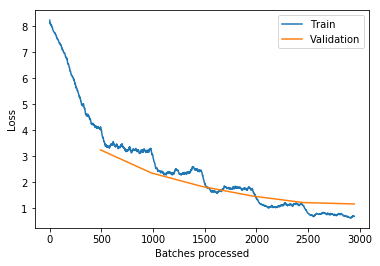

In [22]:
learn.recorder.plot_losses()

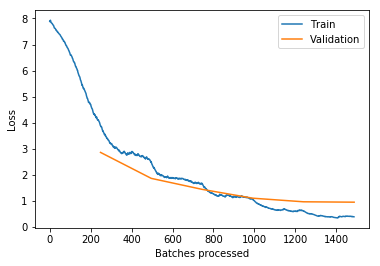

In [55]:
learn.recorder.plot_losses()

### It seems like good results, so save this first iteration of Model Training for future experimenting

In [37]:
learn.save('TC_FirstIteration_6epochs')

In [ ]:
learn.load('TC_FirstIteration_6epochs')

### Unfreezing one layer at a time (especially in text classification) is better than unfreezing everything at once.
### freeze_to(-2)  simply means to unfreeze ONLY the LAST TWO layers for this training iteration.
#### Note:  Here is where we can start to play around with certain hyper-parameters such as LR ranges and momentum

In [23]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-2, 2e-2), moms=(0.7,0.6))

epoch,train_loss,valid_loss,accuracy,time
0,2.806286,2.490214,0.596319,02:33
1,2.172982,1.941217,0.684328,02:30
2,1.372571,1.328269,0.785842,02:40
3,0.729803,1.181941,0.810626,02:45


In [39]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-2, 2e-2), moms=(0.7,0.6))

epoch,train_loss,valid_loss,accuracy,time
0,1.412718,1.640649,0.721405,02:33
1,1.394807,1.266115,0.776389,02:01
2,0.744281,0.887207,0.845046,02:03
3,0.266919,0.782749,0.863717,02:15


### These seem like good results, so let's save the model trained thus far.
#### Note: We could try unfreezing other layers one-by-one prior to unfreezing everything, if we think that might help.

In [40]:
learn.save('TC_SecondIter_4epochs_slice_5eNeg2_2eNeg2_moms0706')

In [ ]:
learn.load('TC_SecondIter_4epochs_slice_5eNeg2_2eNeg2_moms0706')

### Now unfreeze ALL layers and train some more.

In [24]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-2/100, 2e-2), moms=(0.8,0.5))

epoch,train_loss,valid_loss,accuracy,time
0,2.138926,1.894512,0.697240,02:58
1,1.796871,1.493276,0.748293,02:50
2,0.962733,0.960208,0.841051,03:12
3,0.347791,0.872006,0.857079,02:48


In [42]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-2/100, 2e-2), moms=(0.8,0.5))

epoch,train_loss,valid_loss,accuracy,time
0,0.967624,1.279586,0.768597,02:05
1,0.961383,0.904734,0.836666,02:40
2,0.368368,0.653865,0.888268,02:10
3,0.113431,0.609564,0.896207,02:06


### These look like pretty good results (90+ accuracy with seemingly NO Overtraining issues)
### Let's save the final and fully-trained model

In [43]:
learn.save('TC_FinalIter_4epochs_slice_2eNeg2DivBy100_2eNeg2_moms0805')

In [44]:
learn.save_encoder('Final_enc')

### Let's export the fully trained model to be used on other machines (with learn = load_learner()


In [25]:
learn.export('TC_export')
# learn.export()

## We can test our Text Classification (TC) Model :
#### NOTE: Uncomment below if you didn't run the above, or you didn't create a Learn object yet

In [165]:
# learn.load('TC_FinalIter_4epochs_slice_2eNeg2DivBy100_2eNeg2_moms0805')

# or:

# learn.load_encoder('Final_enc')

# or:

# learn= load_learner(PATH, 'TC_export')

### Below we can Test by running Predict with different texts to see if it classifies correctly.

In [32]:
pd.options.display.max_colwidth = 0

# Select a Br ID (label) to test with
BR_ID = np.random.choice(np.array(labels_tst),1,False)[0]
    
t = str(df_tst[df_tst['brand_id']==BR_ID].text)

print(BR_ID, t)

43295 98     has remote work child Karen School are all turned on their heads this year. Everyone is wondering what to do in how to raise successful people. Now available in paperback. The Godmother of Silicon Valley Esther what cheapskate is hear as the voice of Reason? The methods in this book are the opposite of helicopter parenting. As we face an epidemic of parental anxiety, Luchinsky is hear to say, Relax and let your child lead. For instance, talked infants as If they're adults allowed teenagers to pick projects that relate to the real world and let them figure out how to complete them. Above all, let your child lead. How to Raise successful people offers essential lessons for raising, educating and managing children to their highest potential, Arianna Huffington says. How to raise successful people shows us how to be. Are best. So are children can be there best. Does it raise successful people dot com for more information or find a copy wherever books are sold That's raised suc

In [33]:
ix = df_tst[df_tst['brand_id']==BR_ID].index[0]
df_tst.iloc[ix].text

"has remote work child Karen School are all turned on their heads this year. Everyone is wondering what to do in how to raise successful people. Now available in paperback. The Godmother of Silicon Valley Esther what cheapskate is hear as the voice of Reason? The methods in this book are the opposite of helicopter parenting. As we face an epidemic of parental anxiety, Luchinsky is hear to say, Relax and let your child lead. For instance, talked infants as If they're adults allowed teenagers to pick projects that relate to the real world and let them figure out how to complete them. Above all, let your child lead. How to Raise successful people offers essential lessons for raising, educating and managing children to their highest potential, Arianna Huffington says. How to raise successful people shows us how to be. Are best. So are children can be there best. Does it raise successful people dot com for more information or find a copy wherever books are sold That's raised successful peop

In [34]:
learn.predict(t)

(Category 43295,
 tensor(2484),
 tensor([5.0297e-13, 8.0900e-12, 6.0713e-13,  ..., 8.3214e-14, 5.5184e-12,
         1.3585e-11]))